In [23]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fftpack import fft
from scipy.signal import argrelextrema
import pandas as pd

In [24]:
def sine_fit(x, y, plot=True, p0=True):
    """Estimate parameters of a noisy sine wave by FFT and non-linear fitting."""
    
    # Define the sine function
    def sine_func(x, offs, amp, f, phi):
        return offs + amp * np.sin(2 * np.pi * f * x + phi)
    
    # Estimate frequency using FFT
    N = len(y)
    f = np.linspace(0, 1, N)  # Frequency range
    yf = fft(y)
    estimate_f = f[np.argmax(np.abs(yf[1:N//2]))]  # Exclude offset
    
    # Initial guess for the parameters
    guess = [np.mean(y), np.std(y), estimate_f, 0]
    
    # Perform the fit
    if p0:
        popt, pcov = curve_fit(sine_func, x, y, p0=guess)
    else:
        popt, pcov = curve_fit(sine_func, x, y)
    
    # Calculate mean squared error
    mse = np.mean((y - sine_func(x, *popt)) ** 2)
    
    # Append MSE to parameters
    popt = np.append(popt, mse)
    
    # Plot if requested
    if plot:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(x, y,'o', 'b-', label='data')
        x = np.linspace(x[0], x[-1], 1000)
        plt.plot(x, sine_func(x, *popt[:-1]), 'r-', label='fit')
        plt.legend()
        plt.show()
    print(f'mse: {mse}')
    return popt

In [25]:
y = pd.read_csv('ccf_all.csv', header=None).to_numpy()
x = pd.read_csv('lags.csv', header=None).to_numpy().flatten()
ccf_mask = pd.read_csv('ccf_mask.csv', header=None).to_numpy()
ccf_fit_valid = pd.read_csv('ccf_fit_valid.csv', header=None).to_numpy()

ccf_mask = np.array(ccf_mask, dtype=bool).flatten()
ccf_fit_valid = np.array(ccf_fit_valid, dtype=bool).flatten()
valid = ccf_mask & ccf_fit_valid

y_valid = y[valid]
y_invalid = y[~valid]
y_valid.shape

(518, 141)

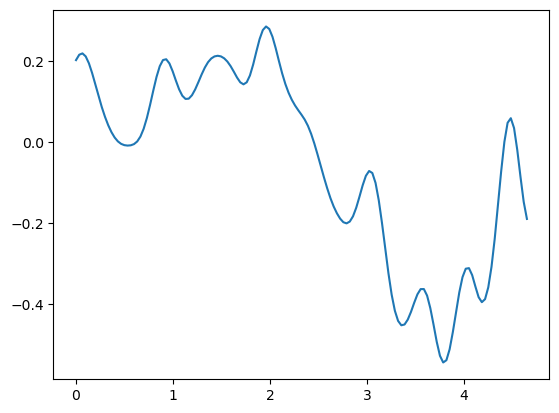

In [26]:
i = 0

plt.plot(x, y_valid[i,:])

/home/roland/Schreibtisch/Capstone/.conda/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/roland/Schreibtisch/Capstone/.conda/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


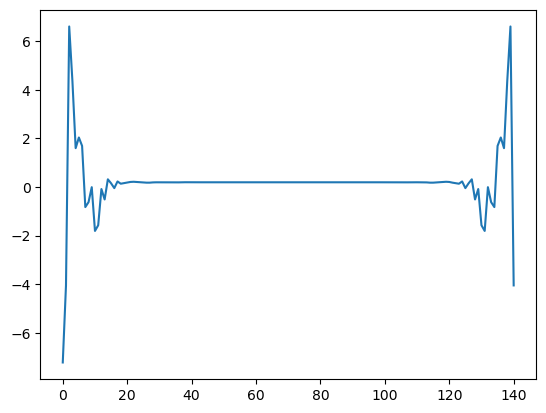

In [27]:

y_fft = fft(y_valid[i])
plt.plot(y_fft)

In [28]:
import ipywidgets as widgets
from IPython.display import display

In [29]:
def calculate_diff(y, idx1, idx2, idx3, idx4, factor):
    
    # find central two extrema
    extrem_2 = y[idx2]
    extrem_3 = y[idx3]
    diff_max = np.abs(extrem_2-extrem_3)
    
    # exclude datapoints
    y_tmp = y.copy()
    if extrem_2 > extrem_3:
        y_tmp[y_tmp > extrem_2] = np.nan
        y_tmp[y_tmp < extrem_3] = np.nan
    else:
        y_tmp[y_tmp > extrem_3] = np.nan
        y_tmp[y_tmp < extrem_2] = np.nan
    
    # find closest nan to the left of idx2
    try:
        idx1 = np.argwhere(np.isnan(y_tmp[:idx2]))[-1][0] + 1
    except IndexError:
        idx1 += 0 
           
    # find closest nan to the right of idx3 until idx4
    try:
        idx4 = np.argwhere(np.isnan(y_tmp[idx3:idx4]))[0][0] + idx3 - 1
    except IndexError:
        idx4 += 0
        
    diff_left = np.abs(y_tmp[idx1]-y_tmp[idx2])
    diff_right = np.abs(y_tmp[idx3]-y_tmp[idx4])
    diff = max(diff_left, diff_right) * factor
    
    if extrem_2 > extrem_3:
        start = idx1 + np.argmin(np.abs(y_tmp[idx1:idx2+1] - (extrem_2 - diff)))
        end = idx3 + np.argmin(np.abs(y_tmp[idx3:idx4+1] - (extrem_3 + diff)))
        return start, end, diff, [idx3, idx2]
    else:
        start = idx1 + np.argmin(np.abs(y_tmp[idx1:idx2+1] - (extrem_2 + diff)))
        end = idx3 + np.argmin(np.abs(y_tmp[idx3:idx4+1] - (extrem_3 - diff)))
        return start, end, diff, [idx2, idx3]

def plot_with_index(index, sinefit=False, save_image=False):
    y = y_valid[index]
    factor = 1/10
    
    # find local maxima
    max_idx = argrelextrema(y, np.greater)[0]
    
    # check if no local maxima
    if len(max_idx) == 0:
        print('no local maxima')
        return
    
    # find local minima
    min_idx = argrelextrema(y, np.less)[0]
    
    # check if no local minima
    if len(min_idx) == 0:
        print('no local minima')
        return None, None, None, None
    
    # exclude saddle points
    max_idx = max_idx[(y[max_idx] > np.roll(y, 1)[max_idx]) & (y[max_idx] > np.roll(y, -1)[max_idx])]
    min_idx = min_idx[(y[min_idx] < np.roll(y, 1)[min_idx]) & (y[min_idx] < np.roll(y, -1)[min_idx])]
    
    # get list of all extrema
    extrema_idx = np.concatenate(([0], max_idx, min_idx))
    
    # remove duplicates
    extrema_idx = np.unique(extrema_idx)
    
    # sort extrema
    extrema_idx = np.sort(extrema_idx)
    
    valid = True
    while valid:
        if len(extrema_idx) >= 4:
            idx1, idx2, idx3, idx4 = extrema_idx[:4]
            if idx3-idx2 < 3:
                extrema_idx = extrema_idx[1:]
                continue
            else:
                start, end, diff, idx = calculate_diff(y, idx1, idx2, idx3, idx4, factor)
                print(f'diff: {diff}')
                valid = False
        if len(extrema_idx) == 3:
            idx1, idx2, idx3 = extrema_idx
            idx4 = len(y)-1
            start, end, diff, idx = calculate_diff(y, idx1, idx2, idx3, idx4, factor)
            print(f'diff: {diff}')
            valid = False
        
    y_crop = y[start:end+1]
    x_crop = x[start:end+1]
    if sinefit:
        # fit sine wave
        params = sine_fit(x_crop, y_crop, plot=False)
        amp_max = np.abs(y[idx3]-y[idx2])
        if params[1] > amp_max:
            print(f'sine fit amplitude too large: {params[1]} > {amp_max}')
        print(params)
            
    x_fit = np.linspace(0, x_crop[-1]+0.5, 100)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax2.plot(x_crop, y_crop, 'o', lw=3)
    tmp = min(np.abs(start-2), start)
    ax2.set_xlim(x[tmp], x[end+2])
    ax2.set_ylim(min(y_crop)-0.2*(max(y_crop)-min(y_crop)), max(y_crop)*1.2)
    
    ax1.plot(x, y, 'o')
    ax1.vlines(x_crop[0], ymin=min(y), ymax=max(y), colors='k', linestyles='dashed')
    ax1.vlines(x_crop[-1], ymin=min(y), ymax=max(y), colors='k', linestyles='dashed')
    

    
    ax2.plot(x_crop, y_crop, 'o')
    ax2.hlines(y[idx[1]]-diff, x_crop[0], x_crop[-1], 'b', ls='--')
    ax2.hlines(y[idx[0]]+diff, x_crop[0], x_crop[-1], 'b', ls='--')
    ax2.vlines(x[idx[0]], min(y_crop), max(y_crop), 'r', ls='--')
    ax2.vlines(x[idx[1]], min(y_crop), max(y_crop), 'r', ls='--')
    ax2.plot([x[start], x[end]], [y[start], y[end]], 'o', color='m')
    # plot sine wave
    if sinefit:
        
        ax1.plot(x_fit, params[0] + params[1] * np.sin(2 * np.pi * params[2] * x_fit + params[3]), 'k--', lw=2)
        ax2.plot(x_fit, params[0] + params[1] * np.sin(2 * np.pi * params[2] * x_fit + params[3]), 'k--', lw=2)
        
        
    plt.show()
    if save_image:
        fig.savefig(f'ccf_fit_{index}.png')
slider = widgets.IntSlider(min=0, max=len(y_valid)-1, step=1, value=0)
sinefit_checkbox = widgets.Checkbox(value=False, description='Sinefit')
save_checkbox = widgets.Checkbox(value=False, description='save_image')
widgets.interact(plot_with_index, index=slider, sinefit=sinefit_checkbox)



interactive(children=(IntSlider(value=0, description='index', max=517), Checkbox(value=False, description='Sin…

<function __main__.plot_with_index(index, sinefit=False)>